In [1]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import tqdm.auto as tqdm
import time

In [2]:
class FaceDataset(data.Dataset):
    def __init__(self, path):
        data = torch.tensor(pd.read_csv(path, header=None).values)
        y, X = data[:,0], data[:,1:]
        y = y.squeeze()
        self.X = X.float()
        self.y = y.long()
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [22]:
class NN(nn.Module):
    def __init__(self, activ=F.sigmoid):
        super().__init__()
        self.fc1 = nn.Linear(2304, 100)
        self.fc2 = nn.Linear(100, 7)
        self.output = nn.Softmax(dim=1)
        self.activ = activ
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self, X):
        X = self.activ(self.fc1(X))
        X = self.fc2(X)
        return self.output(X)
    
    def predict(self, X):
        return torch.argmax(self(X), dim=-1)
    
    def criterion(self, y, yhat):
        return self.cross_entropy(yhat, y)

In [4]:
def train_epoch(net, opt, loader):
    losses = []
    for X, y in loader:
        yhat = net(X)
        loss = net.criterion(y, yhat)
        losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    return losses

In [17]:
def train(net, opt, loader, eps=1e-6):
    losses = []
    prev_loss = float('inf')
    while True:
        new_losses = train_epoch(net, opt, loader)
        loss = sum(new_losses)/len(new_losses)
        if prev_loss - loss < eps:
            break
        prev_loss = loss
        losses += new_losses
    return losses

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_set = FaceDataset('train.csv').to(device)

In [8]:
test_set = FaceDataset('test.csv').to(device)

--------------------------------------------------------------------------------
activation function: <built-in method sigmoid of type object at 0x2b2c94182900>


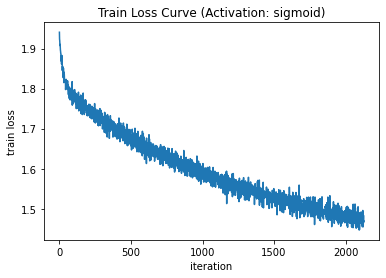

train accuracy: 0.7050990916597853
test accuracy: 0.3892243381328379
convergence time: 37.501925468444824
--------------------------------------------------------------------------------
activation function: <built-in method tanh of type object at 0x2b2c94182900>


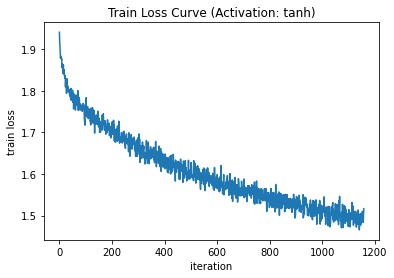

train accuracy: 0.6862613542526838
test accuracy: 0.3966558290757083
convergence time: 20.739819526672363
--------------------------------------------------------------------------------
activation function: <function relu at 0x2b2cd94bae18>


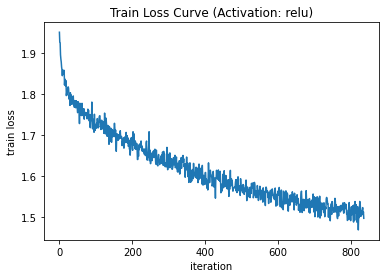

train accuracy: 0.6704170107349298
test accuracy: 0.4088868245858492
convergence time: 15.31593132019043
--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


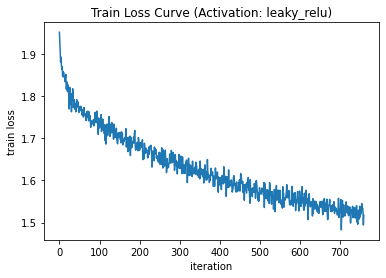

train accuracy: 0.6637592898431048
test accuracy: 0.4090416473138257
convergence time: 13.869333505630493


In [25]:
trials = [('sigmoid',torch.sigmoid), ('tanh',torch.tanh), ('relu',F.relu), ('leaky_relu',F.leaky_relu)]
for name, activ in trials:
    print('-'*80)
    print('activation function:', activ)
    net = NN(activ=activ).to(device)
    opt = optim.Adam(net.parameters(), lr=1e-3)
    loader = data.DataLoader(train_set, 1024, shuffle=True)
    tic = time.time()
    losses = train(net, opt, loader, eps=1e-8)
    toc = time.time()
    plt.plot(losses)
    plt.xlabel('iteration')
    plt.ylabel('train loss')
    plt.title(f'Train Loss Curve (Activation: {name})')
    plt.show()
    print('train accuracy:', accuracy_score(train_set.y.cpu(), net.predict(train_set.X).cpu()))
    print('test accuracy:', accuracy_score(test_set.y.cpu(), net.predict(test_set.X).cpu()))
    print('convergence time:', toc-tic)